<a href="https://colab.research.google.com/github/shanikairoshi/QFL-with-DUN/blob/main/QiskitVQC_FLNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit
!pip install qiskit_machine_learning
# installing TensorFLow Version 2.3.1
from IPython.display import clear_output

clear_output()

In [2]:
#Split data among clients
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit.utils import algorithm_globals
import numpy as np
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms.classifiers import VQC
#from qiskit_machine_learning.optimizers import SPSA
from qiskit import BasicAer
from qiskit import BasicAer, execute
from qiskit.algorithms.optimizers import SPSA

#from DUNWeightingFramework import *
#This is to get client weights which get by classical learning - preprocess.

# Set random seed
algorithm_globals.random_seed = 3142
np.random.seed(algorithm_globals.random_seed)

# Define the feature map and variational form
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Combine feature map and variational form to create the circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()


┌───┐┌─────────────┐                                          ┌───┐»
   q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
        ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├───┤»
   q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
        └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└───┘»
meas: 2/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌─────────────┐                                          ┌──────────┐»
«   q_0: ┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ Ry(θ[0]) ├»
«        ├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
«   q_1: ┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ Ry(θ[1]) ├»
«        └─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«meas: 2/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«        ┌──────────┐   ┌──────────┐┌──────────┐   ┌──────────┐┌───────────┐ ░ »
«   q_0: ┤ Rz(θ[2]) ├─■─┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├─■─┤ Ry(θ[8]) ├┤ Rz(θ[10]) ├─░─»
«        ├──────────┤ │ ├──────────┤├──────────┤ │ ├──────────┤├───────────┤ ░ »
«   q_1: ┤ Rz(θ[3]) ├─■─┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├─■─┤ Ry(θ[9]) ├┤ Rz(θ[11]) ├─░─»
«        └──────────┘   └──────────┘└──────────┘   └──────────┘└───────────┘ ░ »
«meas: 2/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌─┐   
«   q_0: ┤M├───
«        └╥┘┌─┐
«   q_1: ─╫─┤M├
«         ║ └╥┘
«meas: 2/═╩══╩═
«         0  1

In [3]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)


def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [4]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

In [5]:
def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [6]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

In [7]:
def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

In [8]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

In [9]:
# Set up the optimization

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

In [10]:
initial_point = np.random.random(VAR_FORM.num_parameters)
#initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          #0.96566328, 0.38243769, 0.90403094,
                          #0.82271449, 0.26810137, 0.61076489,
                          #0.82301609, 0.11789148, 0.29667125])

In [11]:
VAR_FORM.num_parameters

12

In [12]:
print(initial_point)

[0.68281176 0.53329356 0.30705829 0.36434382 0.84776268 0.62783059
 0.09287432 0.43074988 0.6732609  0.39772681 0.45872596 0.59476781]


In [13]:
# Generate ad hoc data for each client
from sklearn.preprocessing import OneHotEncoder

def generate_client_data(client_id):
    TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
        ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False)
    )
    encoder = OneHotEncoder()
    train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)).toarray()
    test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)).toarray()

    return TRAIN_DATA, train_labels_oh, TEST_DATA, test_labels_oh

# Create a list of client data
client_data = [generate_client_data(client_id) for client_id in range(5)]


In [14]:
'''
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()
'''
'''
from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()
'''

"\nfrom qiskit_machine_learning.algorithms.classifiers import VQC\nlog = OptimizerLog()\nvqc = VQC(feature_map=FEATURE_MAP,\n          ansatz=VAR_FORM,\n          loss='cross_entropy',\n          optimizer=SPSA(callback=log.update),\n          initial_point=initial_point,\n          quantum_instance=BasicAer.get_backend('qasm_simulator'))\n\nvqc.fit(TRAIN_DATA, train_labels_oh)\n\nfig = plt.figure()\nplt.plot(log.evaluations, log.costs)\nplt.xlabel('Steps')\nplt.ylabel('Cost')\nplt.show()\n"

In [15]:
#Global optimizer log
class GlobalOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

global_optimizer_log = GlobalOptimizerLog()

# Initialize global model
global_model = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FORM,
    loss='cross_entropy',
    optimizer=SPSA(callback=global_optimizer_log.update),
    initial_point=initial_point,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

#globallog=GlobalOptimizerLog()


# Initialize global model parameters
#global_optimizer_log.parameters = np.zeros_like(global_parameters)
#global_parameters = np.zeros_like(global_optimizer_log.parameters)

#print(globallog.parameters)




<ipython-input-15-7735fb404e7e>:18: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  global_model = VQC(


In [16]:
# Training settings
num_rounds = 5
learning_rate = 0.01  # Adjust as needed

In [17]:


# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []

global_parameters=[]
global_cost=[]

# Federated training loop
for round_num in range(num_rounds):
     #client_parameters=global_optimizer_log.parameters[-1]
     #print('Round',round_num,'',global_optimizer_log.parameters)
     #print(f"Round {round_num}: global parameters {global_optimizer_log.parameters[-1]}")
    # Aggregate optimizer logs and compute mean gradient
     aggregated_params = []  # List to store aggregated parameters for this round

     #Train each clients data on each vqc to generate client models
     for client_id, data in enumerate(client_data):
          #client_parameters=global_optimizer_log.parameters
          train_data, train_labels, _, _ = data

          log = OptimizerLog()
          #set initial points to the global parameters to fine tune the clients on top of global model
          vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

          vqc.fit(train_data, train_labels)

          clients.append(vqc)
          client_logs.append(log)
          client_parameters.append(log.parameters[-1])
          cost = log.costs[-1]
          print(f"Round {round_num}, Client {client_id}: parameters = {log.parameters[-1]}")
          #print(f"Round {round_num}, Client {client_id}: Cost = {cost}")

          aggregated_params.append(client_parameters[client_id])  # Store client's updated parameters

        # Print the cost for each client in each round
         # Aggregation step
     aggregated_params = np.mean(aggregated_params, axis=0)  # Calculate mean of parameters

     # Update global parameters for the next round
     global_parameters = aggregated_params
     # Aggregate client parameters
     print(f"Round {round_num},global: aggregated_gradients = {global_parameters}")

     # Update the global optimizer log with the aggregated parameters
     global_optimizer_log.parameters.append(global_parameters)
     global_model.fit(train_data, train_labels)
     global_cost = global_optimizer_log.costs
     print(f"Round {round_num},global cost: {global_cost}")


ValueError: ignored

Round 0, Global parameters: [1.32223557 0.3665868  0.31417572 0.68778027 0.65046373 0.69600011
 0.92514002 0.52202381 0.31145532 0.35860698 0.34393596 1.06147695]
Round 0, Global Cost: 0.30891148429336196
Round 1, Global parameters: [ 1.40057099 -0.53502266 -0.07108722  0.70274999  0.3787337   0.90033019
  1.95181334  0.8050515   0.04895603  0.73844726 -0.54780219  0.97760504]
Round 1, Global Cost: 0.30061601087623907
Round 2, Global parameters: [ 1.28255568 -1.55515213 -0.52890506 -0.68203614  0.60459122  1.80146601
  1.51998236  1.24865072 -0.64130218  0.69705631 -0.44211458  0.69570415]
Round 2, Global Cost: 0.30061601087623907
Round 3, Global parameters: [ 1.33147933 -0.13273482 -0.13840594 -0.25495565  0.64795671  2.39441861
  1.47885605 -0.10187743 -1.03867536  0.82539239 -1.13694061  1.01253839]
Round 3, Global Cost: 0.2976748219028327
Round 4, Global parameters: [ 0.64661789 -0.36831166 -0.0612208   0.47084905  0.40464654  2.08947103
  1.26256099 -0.61003654 -0.49359747  0.5954

Round 4, Global Cost: 0.2863973599301315
Global cost over communication rounds: 
[0.30891148429336196, 0.30061601087623907, 0.30061601087623907, 0.2976748219028327, 0.2863973599301315]


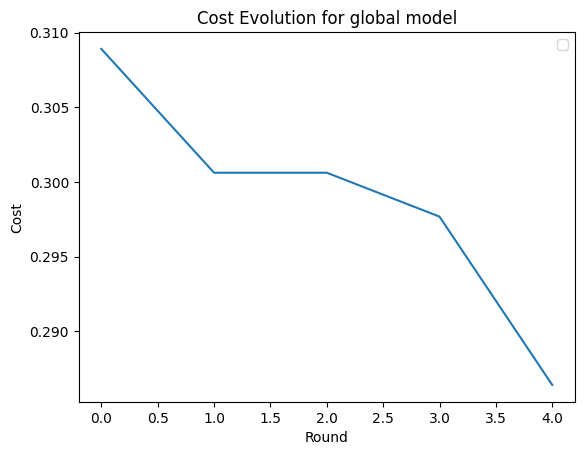

In [18]:
import numpy as np

# Define  existing code here
GlobalCostperRound=[]
clients=[]
client_parameters=[]
client_logs=[]

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values

# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

    # Train each client's data on their VQC models
    for client_id, data in enumerate(client_data):
        train_data, train_labels, _, _ = data

        log = OptimizerLog()

        vqc = VQC(
            feature_map=FEATURE_MAP,
            ansatz=VAR_FORM,
            loss='cross_entropy',
            optimizer=SPSA(callback=log.update),
            initial_point=global_parameters,
            quantum_instance=BasicAer.get_backend('qasm_simulator')
            #statevector_simulator
        )

        vqc.fit(train_data, train_labels)

        clients.append(vqc)
        client_logs.append(log)

        # Append the latest parameters to the client_parameters list
        client_parameters.append(log.parameters[-1])
        cost = log.costs[-1]
        #print(f"Round {round_num}, Client {client_id}: parameters = {log.parameters[-1]}")

        # Add the client's latest parameters to the aggregated_params
        aggregated_params += log.parameters[-1]

    # Average the aggregated parameters across clients
    aggregated_params /= len(client_data)

    # Update global parameters for the next round
    global_parameters = aggregated_params

    # Perform any global updates, e.g., update the global VQC model using global_parameters
    #global_vqc.update_params(global_parameters)

    # Print aggregated parameters and global updates
    print(f"Round {round_num}, Global parameters: {global_parameters}")
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num}, Global Cost: {min(global_cost)}")

    GlobalCostperRound.append(min(global_cost))

print("======================================")
print("Global cost over communication rounds: ")
print(GlobalCostperRound)

#each client cost variations over epochs
import matplotlib.pyplot as plt
#epoch = len(global_optimizer_log.evaluations)
num_rounds= [i for i in range(5)]
plt.plot(num_rounds, GlobalCostperRound)
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('Cost Evolution for global model')
plt.legend()
plt.show()


In [21]:
import numpy as np
# Training settings

num_rounds = 5
learning_rate = 0.01  # Adjust as needed
# Define  existing code here
GlobalCostperRound=[]
clients=[]
client_parameters=[]
client_logs=[]

# Define your existing code here

# Initialize global parameters
global_parameters = np.random.rand(VAR_FORM.num_parameters)  # Initialize with random values or any desired initial values

# Initialize weights for each client
client_weights = [0.2256, 0.1910, 0.1922, 0.1921, 0.1990]  # Adjust weights as needed

#For each round I need to run DUN code and get the client weights.

# Federated training loop
# Federated training loop
for round_num in range(num_rounds):
    global_cost=[]
    aggregated_params = np.zeros_like(global_parameters)  # Initialize aggregated parameters

    # Train each client's data on their VQC models
    for client_id, data in enumerate(client_data):
        train_data, train_labels, _, _ = data

        log = OptimizerLog()

        vqc = VQC(
            feature_map=FEATURE_MAP,
            ansatz=VAR_FORM,
            loss='cross_entropy',
            optimizer=SPSA(callback=log.update),
            initial_point=global_parameters,
            quantum_instance=BasicAer.get_backend('qasm_simulator')
        )

        vqc.fit(train_data, train_labels)

        clients.append(vqc)
        client_logs.append(log)

        # Append the latest parameters to the client_parameters list
        client_parameters.append(log.parameters[-1])
        cost = log.costs[-1]
        #print(f"Round {round_num}, Client {client_id}: parameters = {log.parameters[-1]}")

        # Add the client's latest parameters to the aggregated_params
        aggregated_params += (client_weights[client_id] *log.parameters[-1])
        #aggregated_params.append(client_weights[client_id] * client_parameters[client_id])

     # Weighted aggregation step
    weighted_aggregated_params = np.sum(aggregated_params, axis=0) / np.sum(client_weights)

     #aggregated_params = np.mean(aggregated_params, axis=0)  # Calculate mean of parameters

     # Update global parameters for the next round
    global_parameters = weighted_aggregated_params  # Update global parameters with weighted aggregated values

     # Update global parameters for the next round
    global_parameters = aggregated_params

    # Perform any global updates, e.g., update the global VQC model using global_parameters
    #global_vqc.update_params(global_parameters)


        # Print aggregated parameters and global updates
    #print(f"Round {round_num}, Global parameters: {global_parameters}")
    global_model.fit(train_data, train_labels)
    global_cost = global_optimizer_log.costs
    print(f"Round {round_num}, Global Cost: {global_cost[-1]}")

    GlobalCostperRound.append(min(global_cost))

print("======================================")
print("Global cost over communication rounds: ")
print(GlobalCostperRound)


Round 0, Global Cost: 0.3136780689835496
Round 1, Global Cost: 0.30948770361546973
Round 2, Global Cost: 0.291775810399544
Round 3, Global Cost: 0.29861734173037624
Round 4, Global Cost: 0.3020359147335202
Global cost over communication rounds: 
[0.2863973599301315, 0.2863973599301315, 0.2861154094947828, 0.2861154094947828, 0.2861154094947828]


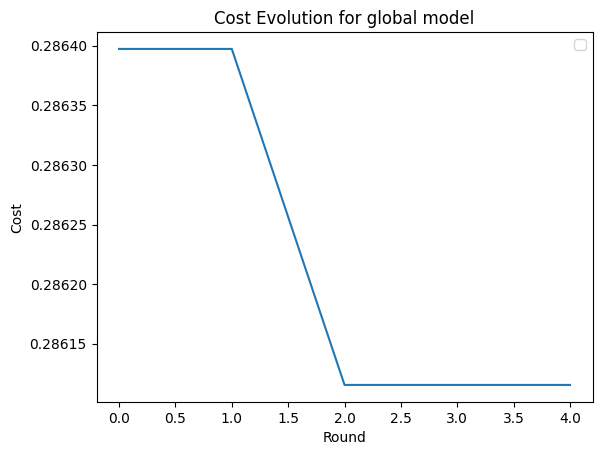

In [23]:

#each client cost variations over epochs
import matplotlib.pyplot as plt
#epoch = len(global_optimizer_log.evaluations)
num_rounds= [i for i in range(5)]
plt.plot(num_rounds, GlobalCostperRound)
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('Cost Evolution for global model')
plt.legend()
plt.show()

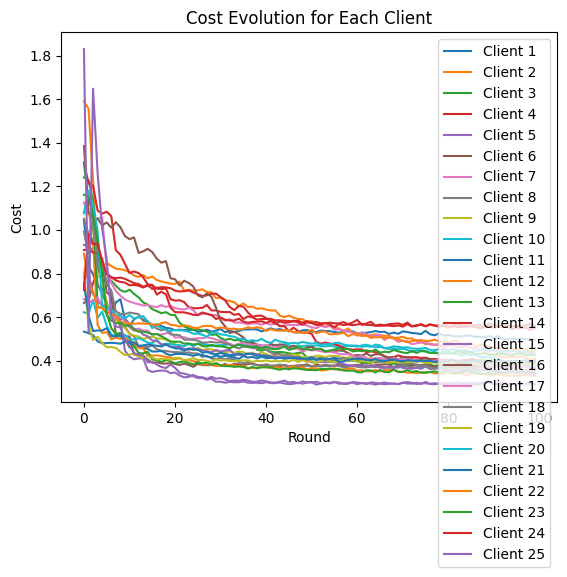

In [24]:

#each client cost variations over epochs
import matplotlib.pyplot as plt
# Plot cost for each client over rounds
epoch = len(client_logs[0].evaluations)
for client_id, log in enumerate(client_logs):
    plt.plot(range(epoch), log.costs, label=f'Client {client_id + 1}')
#plt.plot(range(epoch), global_optimizer_log.costs, label='Global Cost')
plt.xlabel('Round')
plt.ylabel('Cost')
plt.title('Cost Evolution for Each Client')
plt.legend()
plt.show()


Weighted Aggregation


In [ ]:

# Create a list of VQC instances, one for each client
clients = []
# Initialize an empty list to store client logs
client_logs = []
# Initialize an empty list to store client parameters
client_parameters = []

global_parameters=[]
global_cost=[]

# Initialize weights for each client
client_weights = [0.2, 0.3, 0.5, 0.4, 0.7]  # Adjust weights as needed

# Federated training loop
for round_num in range(num_rounds):
     #client_parameters=global_optimizer_log.parameters[-1]
     #print('Round',round_num,'',global_optimizer_log.parameters)
     #print(f"Round {round_num}: global parameters {global_optimizer_log.parameters[-1]}")
    # Aggregate optimizer logs and compute mean gradient
     aggregated_params = []  # List to store aggregated parameters for this round

     #Train each clients data on each vqc to generate client models
     for client_id, data in enumerate(client_data):
          #client_parameters=global_optimizer_log.parameters
          train_data, train_labels, _, _ = data

          log = OptimizerLog()

          vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=global_parameters,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

          vqc.fit(train_data, train_labels)

          clients.append(vqc)
          client_logs.append(log)
          client_parameters.append(log.parameters[-1])
          cost = log.costs[-1]
          print(f"Round {round_num}, Client {client_id}: parameters = {log.parameters[-1]}")
          print(f"Round {round_num}, Client {client_id}: Cost = {cost}")

          aggregated_params.append(client_weights[client_id] * client_parameters[client_id])

          #aggregated_params.append(client_parameters[client_id])  # Store client's updated parameters

        # Print the cost for each client in each round
         # Aggregation step
     # Weighted aggregation step
     weighted_aggregated_params = np.sum(aggregated_params, axis=0) / np.sum(client_weights)

     #aggregated_params = np.mean(aggregated_params, axis=0)  # Calculate mean of parameters

     # Update global parameters for the next round
     global_parameters = weighted_aggregated_params  # Update global parameters with weighted aggregated values

     # Update global parameters for the next round
     global_parameters = aggregated_params
     # Aggregate client parameters
     print(f"Round {round_num},global: aggregated_gradients = {global_parameters}")

     # Update the global optimizer log with the aggregated parameters
     global_optimizer_log.parameters.append(global_parameters)
     global_model.fit(train_data, train_labels)
     global_cost = global_optimizer_log.costs
     print(f"Round {round_num},global cost: {global_cost}")
